**Maëlle Kerleguer**

**L'objectif est de déterminer si le patient devrait être en soins in care ou en out care en fonction de ses résultats. Le tout grâce à un algorithme de Machine Learning supervisé de classification binaire.**

Quelques précisions sur les features avec leur (Name / Data Type / Value Sample/ Description)

HAEMATOCRIT /Continuous /35.1 / Patient laboratory test result of haematocrit

HAEMOGLOBINS/Continuous/11.8 / Patient laboratory test result of haemoglobins

ERYTHROCYTE/Continuous/4.65 / Patient laboratory test result of erythrocyte

LEUCOCYTE /Continuous /6.3 / Patient laboratory test result of leucocyte

THROMBOCYTE/Continuous/310/ Patient laboratory test result of thrombocyte

MCH/Continuous /25.4/ Patient laboratory test result of MCH

MCHC/Continuous/33.6/ Patient laboratory test result of MCHC

MCV/Continuous /75.5/ Patient laboratory test result of MCV

AGE/Continuous/12/ Patient age

SEX/Nominal – Binary/F/ Patient gender

SOURCE/Nominal/ {1,0}/The class target 1.= in care patient, 0 = out care patient


In [266]:
#Importation des librairies nécessaires

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from ydata_profiling import ProfileReport
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, classification_report,  ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [267]:
%matplotlib inline

In [268]:
#Lecture du fichier et indication du séparateur
df=pd.read_csv("patient.csv", sep=';')

C:\Users\maell\AppData\Local\Temp\ipykernel_41916\364404596.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


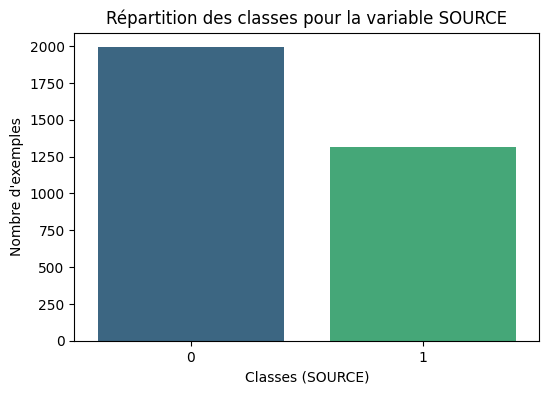

In [269]:
# Compter le nombre d'exemples dans chaque classe de la variable 'SOURCE'
class_counts = df['SOURCE'].value_counts()

# Afficher la répartition des classes sous forme de graphique
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Classes (SOURCE)')
plt.ylabel('Nombre d\'exemples')
plt.title('Répartition des classes pour la variable SOURCE')
plt.show()


**Exploration des données**

In [270]:
#Nombre de données et variables
print(df.shape)

(3309, 11)


In [271]:
# Valeurs manquantes ?
df.isnull().sum()

HAEMATOCRIT     0
HAEMOGLOBINS    0
ERYTHROCYTE     0
LEUCOCYTE       0
THROMBOCYTE     0
MCH             0
MCHC            0
MCV             0
AGE             0
SEX             0
SOURCE          0
dtype: int64

In [272]:
# Vue d'ensemble des données
df.head(10)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   3309 non-null   float64
 1   HAEMOGLOBINS  3309 non-null   float64
 2   ERYTHROCYTE   3309 non-null   float64
 3   LEUCOCYTE     3309 non-null   float64
 4   THROMBOCYTE   3309 non-null   int64  
 5   MCH           3309 non-null   float64
 6   MCHC          3309 non-null   float64
 7   MCV           3309 non-null   float64
 8   AGE           3309 non-null   int64  
 9   SEX           3309 non-null   object 
 10  SOURCE        3309 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 284.5+ KB


HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE    LEUCOCYTE  THROMBOCYTE  \
count  3309.000000   3309.000000  3309.000000  3309.000000  3309.000000   
mean     38.226111     12.749350     4.544802     8.715533   258.893019   
std       5.971943      2.084325     0.784510     4.991299   112.676139   
min      13.700000      3.800000     1.480000     1.100000    10.000000   
25%      34.300000     11.400000     4.040000     5.700000   191.000000   
50%      38.700000     12.900000     4.580000     7.600000   257.000000   
75%      42.500000     14.200000     5.060000    10.300000   322.000000   
max      69.000000     18.900000     7.860000    76.600000  1121.000000   

               MCH         MCHC          MCV          AGE       SOURCE  
count  3309.000000  3309.000000  3309.000000  3309.000000  3309.000000  
mean     28.230039    33.336476    84.611333    46.644303     0.398005  
std       2.696520     1.247055     6.916079    21.874106     0.489561  
min      14.900000    26.000000    54.000000     1.000000     0.000000  
25%      27.200000    32.700000    81.500000    29.000000     0.000000  
50%      28.700000    33.400000    85.300000    48.000000     0.000000  
75%      29.800000    34.100000    88.800000    64.000000     1.000000  
max      40.800000    38.400000   115.600000    99.000000     1.000000

In [273]:
# Afficher les 10 premières lignes
print(df.head(10))

   HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  MCHC  \
0         33.8          11.1         4.18        4.6          150  26.6  32.8   
1         44.6          14.0         6.86        6.3          232  20.4  31.4   
2         42.9          14.0         4.57        6.2          336  30.6  32.6   
3         41.9          14.4         4.67        3.5          276  30.8  34.4   
4         40.6          13.3         4.85       14.9          711  27.4  32.8   
5         32.8          11.2         3.94       11.0          324  28.4  34.1   
6         21.9           7.3         3.06       22.6          237  23.9  33.3   
7         38.4          12.3         4.37        9.0          193  28.1  32.0   
8         27.9           9.2         3.13       19.2          135  29.4  33.0   
9         38.2          12.9         4.53       11.7          452  28.5  33.8   

    MCV  AGE SEX  SOURCE  
0  80.9   33   F       1  
1  65.0   36   M       0  
2  93.9   70   F       0  


Il faut remplacer les caractères F et M pour le sexe par des valeurs numériques pour pouvoir utiliser cette variable dans la suite de l'anayse.

In [274]:
# Pour le sexe : remplacer 'F' par 1 et 'M' par 0
df['SEX'] = df['SEX'].replace({'F': 1, 'M': 0})

C:\Users\maell\AppData\Local\Temp\ipykernel_41916\3567233400.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['SEX'] = df['SEX'].replace({'F': 1, 'M': 0})


**Profiling et data visualisation**

-Le profiling sert à analyser en profondeur un jeu de données afin de mieux comprendre sa structure, ses tendances, et ses caractéristiques statistique

-La datavisualisation est un moyen de présenter les données sous forme graphique pour en faciliter la compréhension. 

In [275]:
# Créer un rapport avec YData Profiling
profile = ProfileReport(df, title="Rapport Exploratoire", explorative=True)

# Afficher le rapport dans le notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Grâce au profiling des données, je remarque qu'il n'y a aucune donnnées manquantes, donc pas de traitements à faire à ce niveau là.

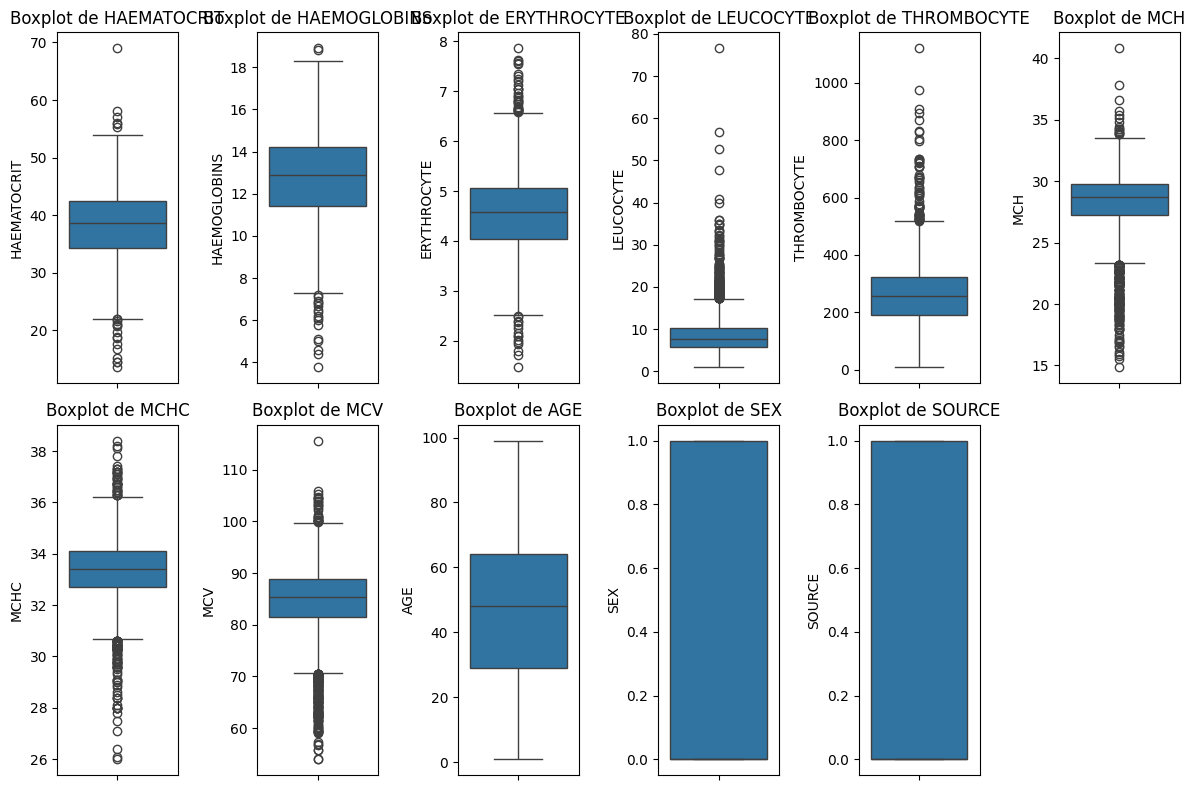

In [276]:
num_cols = len(df.columns)


ncols = 6 
nrows = (num_cols // ncols) + (num_cols % ncols > 0)

# Création d'une figure pour les subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))

axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(data=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()

plt.show()

 Sur ces boîtes à moustache, je remarque de nombreux points en dehors des moustaches sur plusieurs variables (par exemple, Thrombocyte, Leucocyte, MCV), ce qui indique qu'il y a beaucoup de valeurs extrêmes ou outliers dans ces colonnes. Il faudra y porter attention dans le choix des classifiers.

 Aussi, certaines variables montrent une répartition plus centrée, tandis que d'autres (comme Thrombocyte) semblent plus dispersées, avec des valeurs beaucoup plus élevées que la majorité des données.
 Sur ces graphes, il est impossible de voir s'il y a un déséquilibre des classes pour SOURCE, la variable cible.

In [277]:

# Fonction pour détecter les outliers
def detect_outliers_iqr(df):
    # Calcul de l'IQR pour chaque colonne numérique
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Détection des outliers
    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return outliers

# Fonction pour détecter les outliers avec Z-score
def detect_outliers_zscore(df):
    z_scores = np.abs(zscore(df))  # Calcul du Z-score pour chaque valeur
    outliers = (z_scores > 3)  # Seuil de 3 pour les outliers
    return outliers

# Sélectionner les colonnes numériques pour la détection d'outliers
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Détection des outliers avec IQR
outliers_iqr = detect_outliers_iqr(df[numeric_columns])

# Détection des outliers avec Z-score
outliers_zscore = detect_outliers_zscore(df[numeric_columns])

# Combine les résultats des deux méthodes (IQR et Z-score)
outliers_combined = outliers_iqr | outliers_zscore

# Création d'un DataFrame sans les outliers
df_cleaned = df[~outliers_combined.any(axis=1)]

# Afficher la forme du dataset avant et après nettoyage
print(f'Nombre de lignes avant nettoyage : {df.shape[0]}')
print(f'Nombre de lignes après nettoyage : {df_cleaned.shape[0]}')

# Optionnel : vérifier si les outliers ont été supprimés
print(f'Exemples d\'outliers supprimés :')
print(df[outliers_combined.any(axis=1)].head())

# df_cleaned est le dataset sans outliers

Nombre de lignes avant nettoyage : 3309
Nombre de lignes après nettoyage : 2804
Exemples d'outliers supprimés :
    HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
1          44.6          14.0         6.86        6.3          232  20.4   
4          40.6          13.3         4.85       14.9          711  27.4   
6          21.9           7.3         3.06       22.6          237  23.9   
8          27.9           9.2         3.13       19.2          135  29.4   
14         35.9          10.4         5.45        8.0          500  19.1   

    MCHC   MCV  AGE  SEX  SOURCE  
1   31.4  65.0   36    0       0  
4   32.8  83.7   36    0       0  
6   33.3  71.6   53    0       0  
8   33.0  89.1   56    0       1  
14  29.0  65.9   30    0       1  


C:\Users\maell\AppData\Local\Temp\ipykernel_41916\2385601039.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


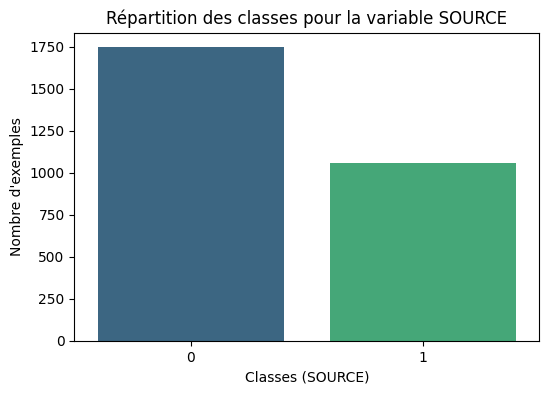

In [278]:
# Compter le nombre d'exemples dans chaque classe de la variable 'SOURCE'
class_counts = df_cleaned['SOURCE'].value_counts()

# Afficher la répartition des classes sous forme de graphique
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Classes (SOURCE)')
plt.ylabel('Nombre d\'exemples')
plt.title('Répartition des classes pour la variable SOURCE')
plt.show()


Grâce à ce graphe, on remarque un déséquilibre assez important, d'autant plus dans le cadre d'une tâche de classification. Je vais donc faire un rééquilibrage des données.

C:\Users\maell\AppData\Local\Temp\ipykernel_41916\2997256350.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_resampled.value_counts().index, y=y_resampled.value_counts().values, palette='viridis')


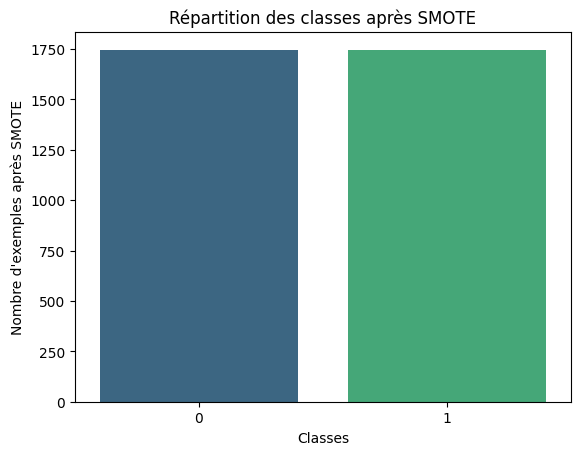

In [279]:
# Sélectionner les features et la cible
X = df_cleaned.drop('SOURCE', axis=1)  
y = df_cleaned['SOURCE']

# Appliquer SMOTE sur l'ensemble d'entraînement après la séparation
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Créer un nouveau DataFrame après le rééchantillonnage
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['SOURCE'] = y_resampled 

# Vérifier la répartition après le rééchantillonnage
sns.barplot(x=y_resampled.value_counts().index, y=y_resampled.value_counts().values, palette='viridis')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'exemples après SMOTE')
plt.title('Répartition des classes après SMOTE')
plt.show()

**Feature selection**

La feature selection améliore la performance des modèles en réduisant la complexité, le surapprentissage et le temps de calcul, en se concentrant sur les variables les plus pertinentes. Elle simplifie l'interprétation du modèle en éliminant les caractéristiques redondantes ou non informatives.


In [280]:
#Identification de la variable cible
X = df.drop('SOURCE', axis=1)
y = df['SOURCE']

In [281]:
# Calculer la variance de chaque colonne
variances = X.var()
print(variances)

HAEMATOCRIT        35.664106
HAEMOGLOBINS        4.344411
ERYTHROCYTE         0.615456
LEUCOCYTE          24.913066
THROMBOCYTE     12695.912373
MCH                 7.271219
MCHC                1.555147
MCV                47.832148
AGE               478.476525
SEX                 0.249360
dtype: float64


In [282]:
# Initialiser un filtre avec un seuil de variance (ici 0,1)
selector = VarianceThreshold(threshold=0.1)
X_filtered = selector.fit_transform(X)

# Obtenir les noms des colonnes sélectionnées
selected_features = X.columns[selector.get_support()]
print("Selected Features (low variance removed):", selected_features.tolist())


Selected Features (low variance removed): ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX']


In [283]:
# Calculer la corrélation entre chaque caractéristique et la cible
correlation = X.corrwith(y)

# Afficher tous les coefficients de corrélation
print("All Features with their Correlation Coefficients:")
for feature, coef in correlation.items():
    print(f"{feature}: {coef:.3f}")

All Features with their Correlation Coefficients:
HAEMATOCRIT: -0.272
HAEMOGLOBINS: -0.255
ERYTHROCYTE: -0.238
LEUCOCYTE: 0.140
THROMBOCYTE: -0.230
MCH: -0.002
MCHC: 0.026
MCV: -0.014
AGE: 0.113
SEX: -0.057


Intéressant de jouer avec les fonctions de sélection des variables, peu de features ici donc une sléection sera faite uniquement si certains modèoles sont trop couteux.

**Algorithmes de classification**

L'objectif ici est de tester différents classifieurs et de déterminer quel est le plus performance pour la classification binaire à réaliser ici. Les différents modèles seront comparé selon leur précision, leur matrice de confusion et leur courbe roc, le temps d'exécution est également intéressant à prendre en compte.

**Logistic Regression**

La régression logistique est un modèle simple et efficace pour les problèmes de classification binaire.

Accuracy: 0.73

Classification Report :
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       532
           1       0.73      0.71      0.72       517

    accuracy                           0.73      1049
   macro avg       0.73      0.73      0.73      1049
weighted avg       0.73      0.73      0.73      1049



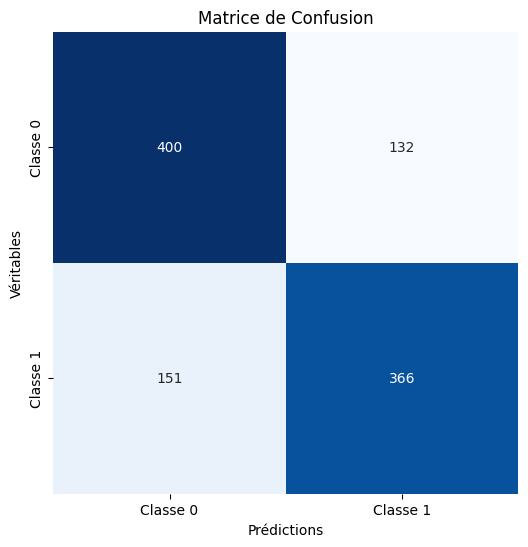

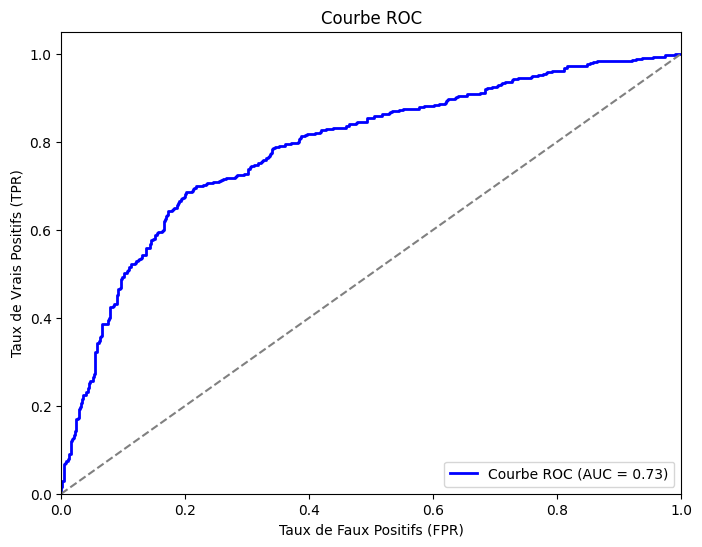

In [284]:
X = df_resampled.drop('SOURCE', axis=1)
y = df_resampled['SOURCE'] 

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Création du modèle de régression logistique
model = LogisticRegression(max_iter=1000)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# 1. Calcul de l'Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 2. Classification Report (précision, rappel, F1-score)
print("\nClassification Report :")
print(classification_report(y_test, y_pred))

# 2. Matrice de Confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de Confusion')
plt.show()

# 3. Courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

**Arbre de décision**

Les arbres de décision sont idéaux pour la classification binaire car ils sont simples à comprendre, offrent des décisions claires et peuvent capturer des relations non linéaires. 

Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       271
           1       0.74      0.68      0.71       254

    accuracy                           0.73       525
   macro avg       0.73      0.73      0.73       525
weighted avg       0.73      0.73      0.73       525

Accuracy: 0.73


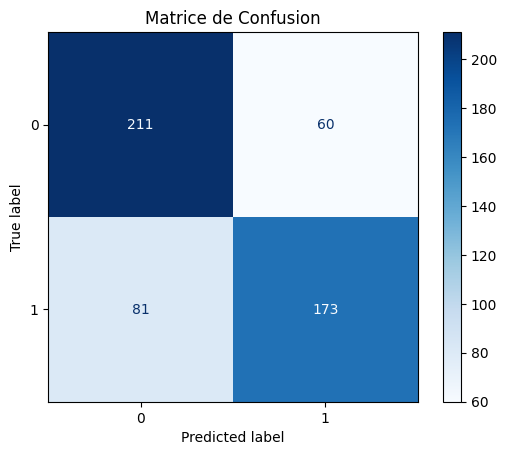

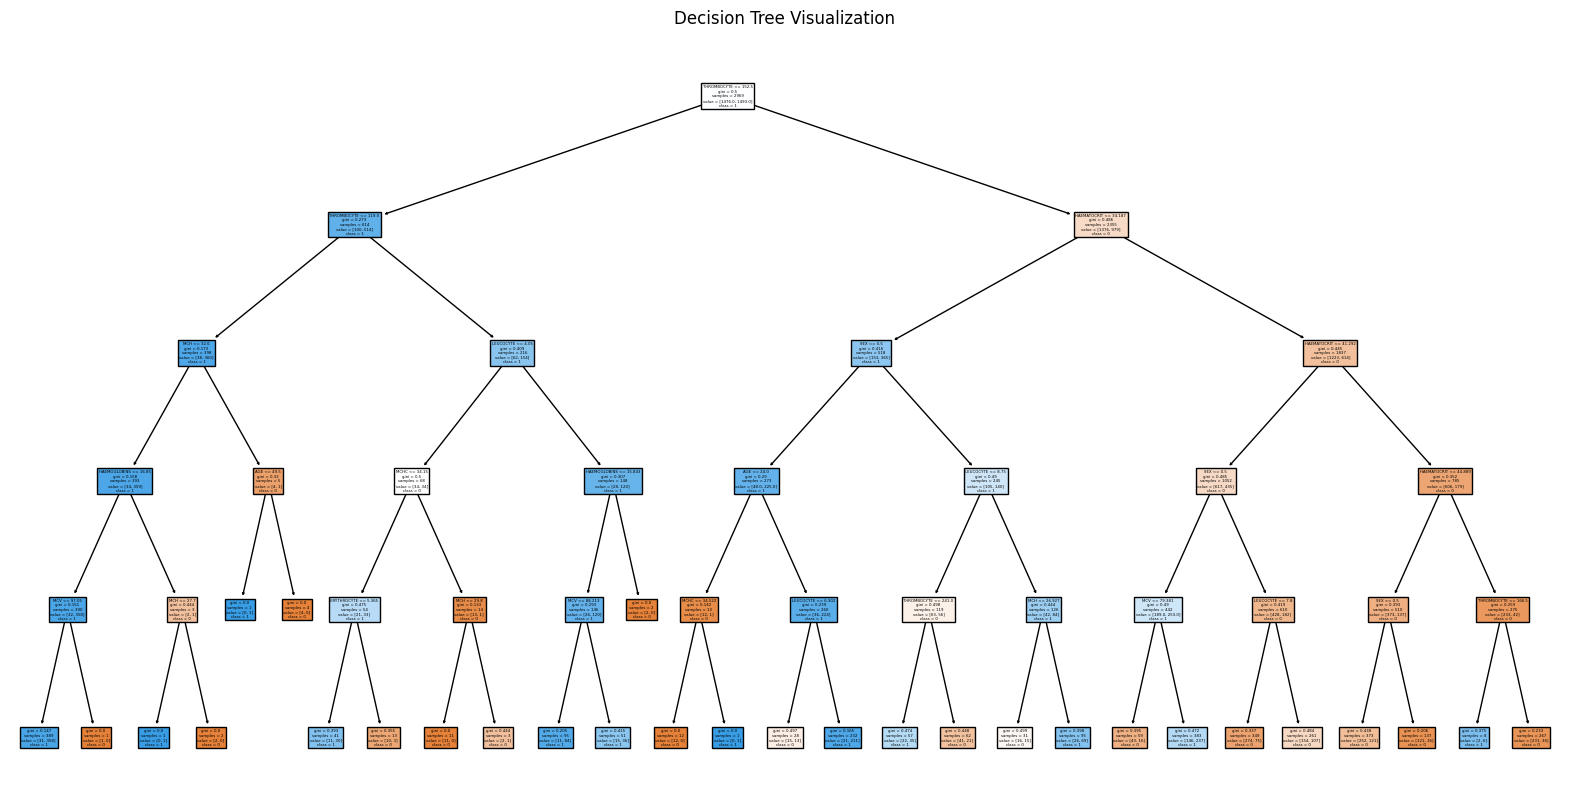

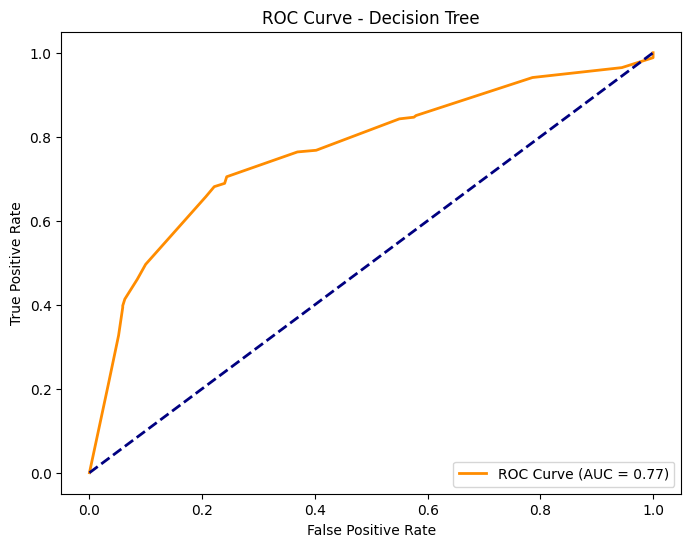

In [285]:

X = df_resampled.drop('SOURCE', axis=1)
y = df_resampled['SOURCE']

# Division des données en ensembles d'entraînement (85%) et de test (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Optimisation de l'arbre de décision avec GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'] 
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et modèle optimal
best_params = grid_search.best_params_
decision_tree = grid_search.best_estimator_
print(f"Meilleurs paramètres : {best_params}")

# Entraînement du modèle optimisé
decision_tree.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = decision_tree.predict(X_test)

# Évaluation du modèle
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

# Visualisation de l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, feature_names=X.columns, class_names=decision_tree.classes_.astype(str), filled=True)
plt.title("Decision Tree Visualization")
plt.show()

# Calcul de la courbe ROC
y_proba = decision_tree.predict_proba(X_test)[:, 1] 

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.show()

**Random Forest**

Un Random Forest pour la classification binaire est une méthode d'apprentissage automatique qui combine plusieurs arbres de décision pour améliorer la précision des prédictions. Chaque arbre est formé sur un sous-ensemble aléatoire des données, et les résultats des arbres sont agrégés par vote majoritaire pour la classification. Il offre souvent une meilleure précision que les arbres de décision mais est plus couteûx.

Meilleurs paramètres : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       271
           1       0.78      0.74      0.76       254

    accuracy                           0.78       525
   macro avg       0.78      0.77      0.77       525
weighted avg       0.78      0.78      0.77       525

Accuracy: 0.78


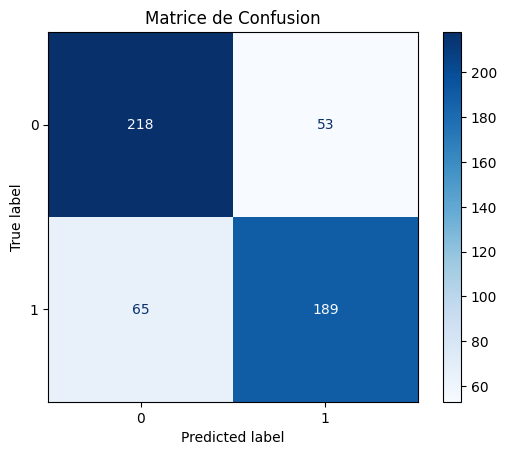

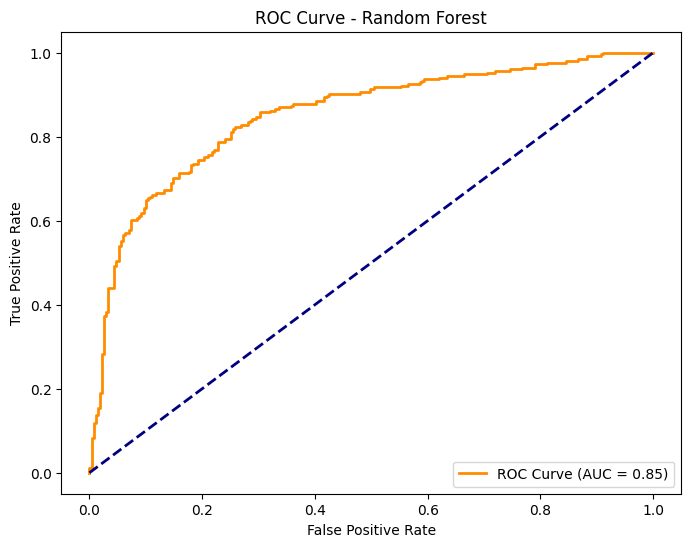

In [286]:
X = df_resampled.drop('SOURCE', axis=1)
y = df_resampled['SOURCE']

# Division des données en ensembles d'entraînement (85%) et de test (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Optimisation du modèle Random Forest avec GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et modèle optimal
best_params = grid_search.best_params_
random_forest = grid_search.best_estimator_
print(f"Meilleurs paramètres : {best_params}")

# Prédictions sur l'ensemble de test
y_pred = random_forest.predict(X_test)

# Évaluation du modèle
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

# Calcul de la courbe ROC
y_proba = random_forest.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive (1)

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()


**K-Nearest Neighbors (KNN)**

Le KNN pour la classification binaire est un algorithme basé sur la proximité des points dans l'espace des caractéristiques. Lorsqu'un nouvel exemple doit être classé, KNN regarde les K voisins les plus proches de cet exemple et attribue la classe la plus fréquente parmi ces voisins. Ce modèle est simple, sans paramètre d'apprentissage, mais sensible à la distance et à la dimension des données.

Accuracy: 0.75


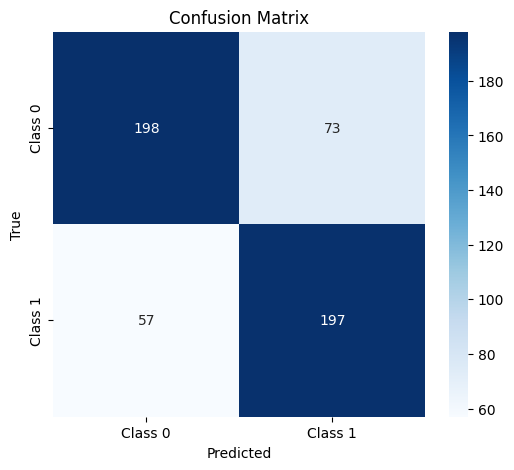

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       271
           1       0.73      0.78      0.75       254

    accuracy                           0.75       525
   macro avg       0.75      0.75      0.75       525
weighted avg       0.75      0.75      0.75       525



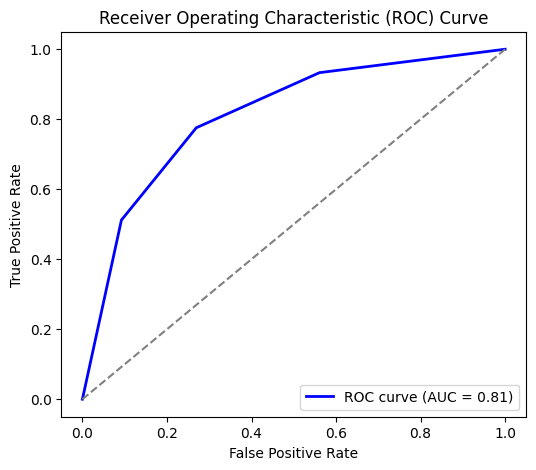

In [287]:
X = df_resampled.drop(columns=['SOURCE']) 
y = df_resampled['SOURCE']

# Division des données en ensemble d'entraînement et de test (15% et 85%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Création du modèle KNN avec K=3
knn = KNeighborsClassifier(n_neighbors=3)

# Entraînement du modèle
knn.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred = knn.predict(X_test_scaled)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**SVM (Support Vector Machine)**

Le SVM (Support Vector Machine) est un algorithme de classification puissant qui sépare les données en maximisant la marge entre les classes, ce qui aide à améliorer la généralisation et à réduire le risque de surapprentissage.

Accuracy: 0.76


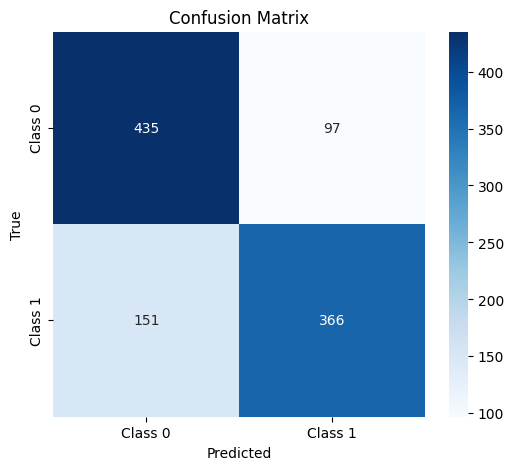

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       532
           1       0.79      0.71      0.75       517

    accuracy                           0.76      1049
   macro avg       0.77      0.76      0.76      1049
weighted avg       0.77      0.76      0.76      1049



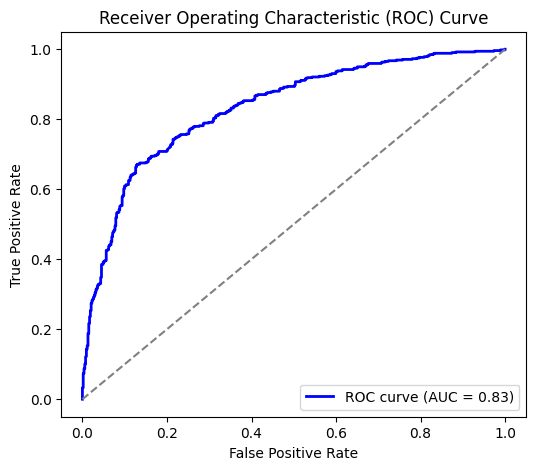

In [288]:
X = df_resampled.drop(columns=['SOURCE'])
y = df_resampled['SOURCE'] 

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Création du modèle SVM avec un noyau RBF (Radial Basis Function)
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Entraînement du modèle
svm.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred = svm.predict(X_test_scaled)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, svm.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Gradient Boosting**


Le Gradient Boosting est un algorithme puissant d'ensemble learning qui combine plusieurs modèles faibles (arbres de décision) pour créer un modèle robuste. Il ajuste successivement les erreurs des prédictions précédentes, améliorant ainsi la précision. Il est particulièrement efficace pour les problèmes de classification, même avec des données complexes et des relations non linéaires.

Accuracy: 0.77
F1 Score: 0.75


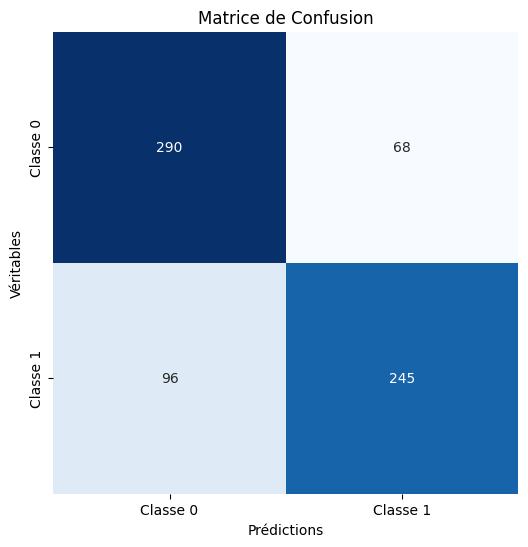

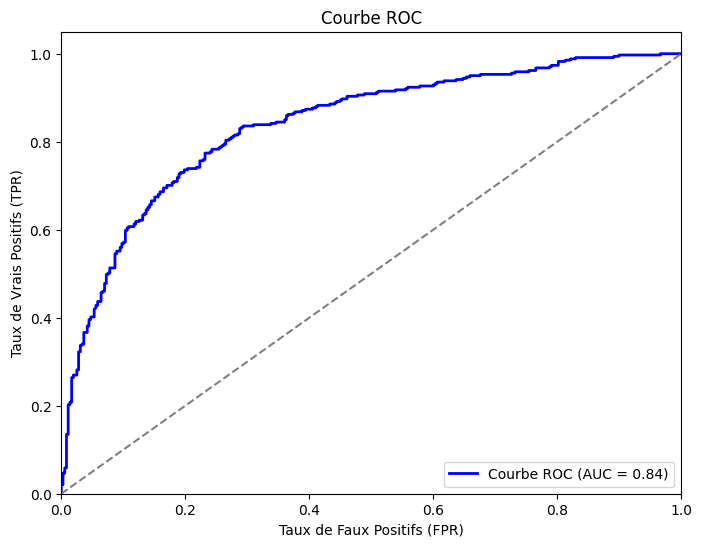

In [289]:
X = df_resampled.drop('SOURCE', axis=1) 
y = df_resampled['SOURCE'] 

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle Gradient Boosting
model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Calcul de l'Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calcul du F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

# Matrice de Confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de Confusion')
plt.show()

# 5. Courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

**XGBoost (Extreme Gradient Boosting)**

XGBoost est un algorithme puissant pour la classification binaire, connu pour sa vitesse et ses performances. Il utilise le gradient boosting pour combiner plusieurs arbres de décision et améliorer les prédictions.

Accuracy: 0.78
Temps d'exécution: 0.13 secondes

Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       358
           1       0.78      0.77      0.78       341

    accuracy                           0.78       699
   macro avg       0.78      0.78      0.78       699
weighted avg       0.78      0.78      0.78       699



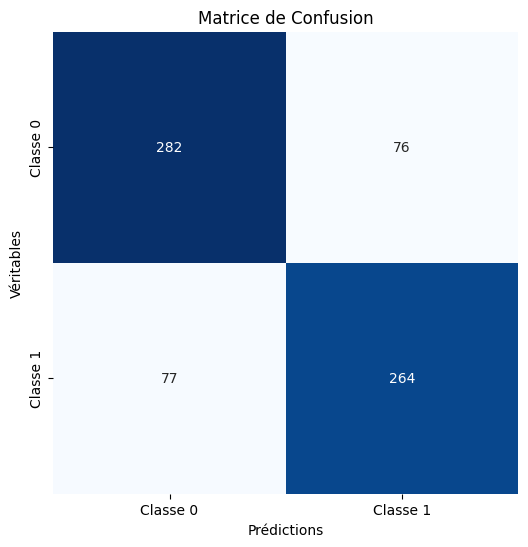

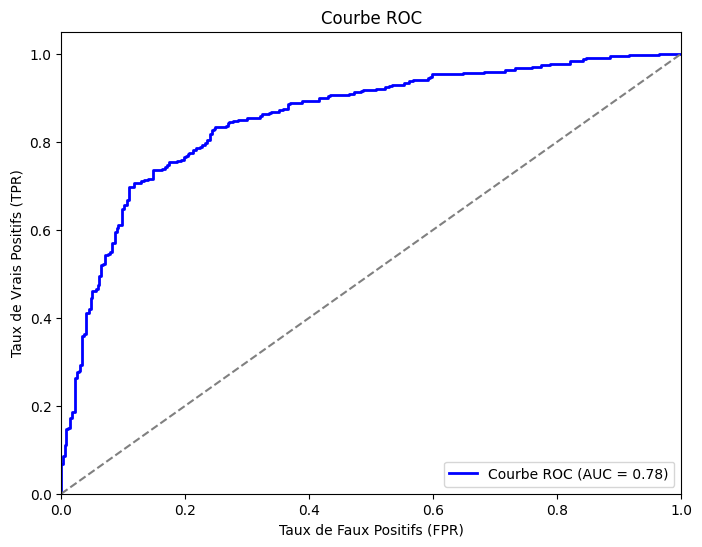

In [290]:
X = df_resampled.drop('SOURCE', axis=1) 
y = df_resampled['SOURCE']

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle XGBoost
model = xgb.XGBClassifier(random_state=42)

# Démarrage du chronométrage
start_time = time.time()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Calcul de l'Accuracy et du ROC AUC
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Affichage des résultats
print(f'Accuracy: {accuracy:.2f}')
print(f'Temps d\'exécution: {execution_time:.2f} secondes')

# Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred))

# Matrice de Confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de Confusion')
plt.show()

# Courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

**Conclusion**

Pour conclure, les classifiers qui offrent les meilleurs résultats avec une accuracy, un F1-score et un AUC les plus élevés sont Random Forest et Gradient Boosting. Cependant le temps d'execution du RF est de 7 minutes contre moins d'une seconde pour le gradient boosting. Le meilleur classifier ici est donc le Gradient Boosting.